In [ ]:
!pip list -v

In [ ]:
!pip install scipy
!pip install sklearn
!pip install matplotlib
!pip install seaborn

#Menyiapkan data yang akan dipakai

Import dataset yang akan digunakan melalui path ke file csv.


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_movies = "/content/drive/My Drive/movie_recommender_system/movies.csv"
movies = pd.read_csv(path_movies)
movies.describe

<bound method NDFrame.describe of       movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|D

In [ ]:
path_ratings = "/content/drive/My Drive/movie_recommender_system/ratings.csv"
ratings = pd.read_csv(path_ratings)
ratings.describe

<bound method NDFrame.describe of         userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]>

Movie dataset has

movieId – once the recommendation is done, we get a list of all similar movieId and get the title for each movie from this dataset.
genres – which is not required for this filtering approach.

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings dataset has-

userId – unique for each user.
movieId – using this feature, we take the title of the movie from the movies dataset.
rating – Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies.

In [ ]:
ratings.head()

In order to make things easier to understand and work with, we are going to make a new dataframe where each column would represent each unique userId and each row represents each unique movieId.

In [ ]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

Impute NaN with 0 to make things understandable for the algorithm and also making the data more eye-soothing.

In [ ]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

# Removing Noise from the data

Ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users.

We wouldn’t want movies that were rated by a small number of users because it’s not credible enough. Similarly, users who have rated only a handful of movies should also not be taken into account.

So with all that taken into account and some trial and error experimentations,  we will reduce the noise by adding some filters for the final dataset.

*   To qualify a movie, a minimum of 10 users should have voted a movie.
*   To qualify a user, a minimum of 50 movies should have voted by the user.

# Let’s visualize how these filters look like

Aggregating the number of users who voted and the number of movies that were voted.


In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

Let’s visualize the number of users who voted with our threshold of 10.

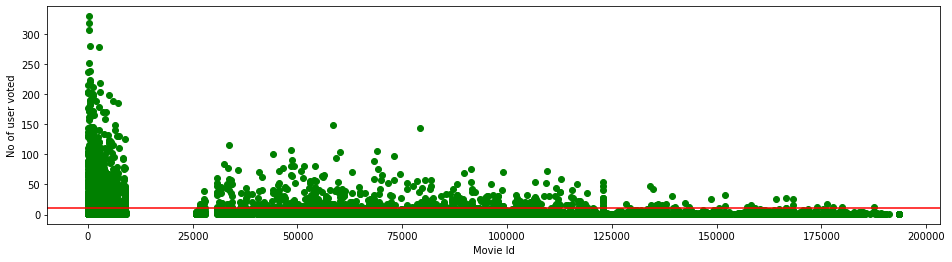

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_user_voted.index, no_user_voted,color='green')
plt.axhline(y=10, color='r')
plt.xlabel('Movie Id')
plt.ylabel('No of user voted')
plt.show()

Making the necessary modifications as per the threshold set.

In [ ]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]
final_dataset

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let’s visualize the number of votes by each user with our threshold of 50.

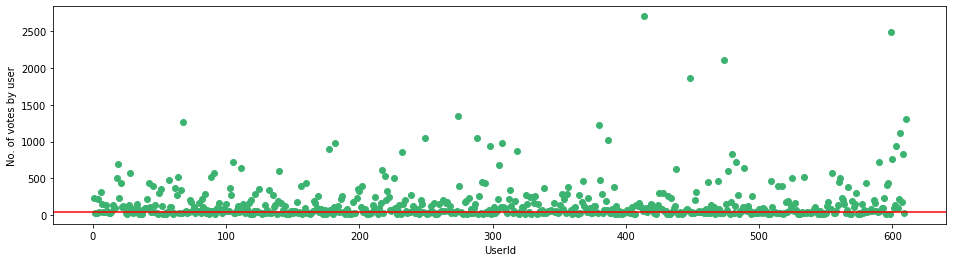

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

Making the necessary modifications as per the threshold set.

In [ ]:
final_dataset = final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Removing sparsity

Our final_dataset has dimensions of 2121 * 378 where most of the values are sparse. We are using only a small dataset but for the original large dataset of movie lens which has more than 100000 features, our system may run out of computational resources when that is feed to the model. To reduce the sparsity we use the csr_matrix function from the scipy library.

In [ ]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)
print(csr_data)

# Making the movie recommendation system model

We will be using the KNN algorithm to compute similarity with cosine distance metric which is very fast and more preferable than pearson coefficient.

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

# Making the recommendation function

Working Principle :
1. Checking if the movie name input is in the database
2. If it is, we use our recommendation system to find similar movies
3. Sort them based on their similarity distance and output only the top 10 movies with their distances from the input movie

In [ ]:
def get_movie_recommendation(movie_name):
  movie_to_recommend_count = 10
  movie_list = movies[movies['title'].str.contains(movie_name)]
  
  if len(movie_list):
    movie_index = movie_list.iloc[0]['movieId']
    movie_index = final_dataset[final_dataset['movieId'] == movie_index].index[0]
    distances, indices = knn.kneighbors(csr_data[movie_index], n_neighbors=movie_to_recommend_count+1)
    rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    recommend_frame = []
    for val in rec_movie_indices:
      movie_index = final_dataset.iloc[val[0]]['movieId']
      index = movies[movies['movieId']==movie_index].index
      recommend_frame.append({'Title':movies.iloc[index]['title'].values[0],'Distance':val[1]})
    
    df = pd.DataFrame(recommend_frame, index=range(1,movie_to_recommend_count+1))
    return df
  else :
    return "No movies found. Please check your input"

# Finally, Let’s Recommend some movies!

In [ ]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,X-Men: First Class (2011),1.111104e-07
2,Guardians of the Galaxy (2014),1.106718e-07
3,District 9 (2009),1.085074e-07
4,Sherlock Holmes (2009),1.077268e-07
5,Kung Fu Panda (2008),1.066761e-07
6,Watchmen (2009),1.061401e-07
7,Star Trek (2009),1.047793e-07
8,Iron Man 2 (2010),9.618056e-08
9,Avatar (2009),9.313901e-08
10,"Avengers, The (2012)",8.755834e-08


In [ ]:
get_movie_recommendation('Memento')

,Title,Distance
1,Spider-Man (2002),0.000047
2,Pirates of the Caribbean: The Curse of the Bla...,0.000047
3,Donnie Darko (2001),0.000047
4,Kill Bill: Vol. 2 (2004),0.000047
5,Minority Report (2002),0.000047
6,"Lord of the Rings: The Return of the King, The...",0.000043
7,Eternal Sunshine of the Spotless Mind (2004),0.000042
8,Kill Bill: Vol. 1 (2003),0.000042
9,"Lord of the Rings: The Two Towers, The (2002)",0.000041
10,"Lord of the Rings: The Fellowship of the Ring,...",0.000041


In [ ]:
get_movie_recommendation('Hulk')

,Title,Distance
1,Pirates of the Caribbean: Dead Man's Chest (2006),0.000003
2,Serenity (2005),0.000002
3,V for Vendetta (2006),0.000002
4,X-Men: The Last Stand (2006),0.000002
5,Constantine (2005),0.000002
6,Batman Begins (2005),0.000002
7,Daredevil (2003),0.000002
8,Sin City (2005),0.000002
9,Fantastic Four (2005),0.000002
10,Star Wars: Episode III - Revenge of the Sith (...,0.000002


In [ ]:
get_movie_recommendation('Toy Story')

,Title,Distance
1,Get Shorty (1995),0.667291
2,"American President, The (1995)",0.654263
3,Ace Ventura: When Nature Calls (1995),0.643325
4,"Usual Suspects, The (1995)",0.604626
5,Heat (1995),0.598764
6,Seven (a.k.a. Se7en) (1995),0.596986
7,GoldenEye (1995),0.550048
8,Jumanji (1995),0.547825
9,Babe (1995),0.539493
10,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.534670
